# XGBoost Training 

This notebook demonstrates how to train an XGBoost model using a PCA-transformed dataset while addressing class imbalance with SMOTE and optimizing hyperparameters using Optuna. The performance is evaluated using a custom entropy-based scoring method.




In [29]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import (
    train_test_split, StratifiedKFold
)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, precision_recall_curve, auc
)
from imblearn.over_sampling import SMOTE  # Change from ADASYN to SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import xgboost as xgb
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner
import warnings
import time
import json
import pickle
from datetime import datetime

# Suppress warnings and Optuna logs
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


## Load  Data

Load the  dataset and inspect its structure and target distribution.


In [ ]:
def load_pca_data(filepath):
    """Load  data."""
    print("=" * 80)
    print("LOADING  DATASET")
    print("=" * 80)
    
    # Load data
    df = pd.read_csv(filepath)
    print(f"Dataset shape: {df.shape}")
    print(f"Features: {df.columns.tolist()[:-1]}")
    print(f"Target column: {df.columns[-1]}")
    
    # Basic info about the dataset
    print(f"\nTarget distribution:")
    print(df['target'].value_counts())
    print(f"Target distribution (%):")
    print(df['target'].value_counts(normalize=True) * 100)
    
    # Check for missing values
    missing_values = df.isnull().sum()
    if missing_values.any():
        print(f"\nMissing values:")
        print(missing_values[missing_values > 0])
    else:
        print("\nNo missing values found.")
    
    return df

# Load the dataset
dataset_name = 'heart_3datasets_proper_pca_BEST.csv'
df = load_pca_data(dataset_name)


LOADING PCA 95% VARIANCE DATASET
Dataset shape: (2919, 12)
Features: ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11']
Target column: target

Target distribution:
target
1    1577
0    1342
Name: count, dtype: int64
Target distribution (%):
target
1    54.025351
0    45.974649
Name: proportion, dtype: float64

No missing values found.


## Prepare Features and Target

Separate the features and target variable, converting to a binary classification problem.


In [31]:
def prepare_features_target(df):
    """Separate features and target, converting to binary classification."""
    # Separate features and target
    X = df.drop('target', axis=1)
    y = df['target']
    
    # Convert to binary classification (0 vs non-0)
    print(f"\nOriginal target distribution:")
    print(y.value_counts().sort_index())
    
    # Convert multiclass to binary: 0 stays 0, everything else becomes 1
    y_binary = (y != 0).astype(int)
    
    print(f"\nConverted to binary target distribution:")
    print(y_binary.value_counts().sort_index())
    print(f"Binary target distribution (%):")
    print(y_binary.value_counts(normalize=True).sort_index() * 100)
    
    print(f"\nFeatures shape: {X.shape}")
    print(f"Target shape: {y_binary.shape}")
    print(f"Feature columns: {X.columns.tolist()}")
    
    return X, y_binary

# Prepare features and target
X, y = prepare_features_target(df)



Original target distribution:
target
0    1342
1    1577
Name: count, dtype: int64

Converted to binary target distribution:
target
0    1342
1    1577
Name: count, dtype: int64
Binary target distribution (%):
target
0    45.974649
1    54.025351
Name: proportion, dtype: float64

Features shape: (2919, 11)
Target shape: (2919,)
Feature columns: ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11']


## Split Data

Split the dataset into training and test sets.


In [32]:
print("\n" + "=" * 80)
print("SPLITTING DATA")
print("=" * 80)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")



SPLITTING DATA
Training set: 2335 samples
Test set: 584 samples


## Create XGBoost Pipeline

Define a pipeline that includes scaling, ADASYN for handling class imbalance, and the XGBoost classifier.


In [33]:
def create_xgboost_pipeline():
    """Create XGBoost pipeline with SMOTE."""
    print("\n" + "=" * 80)
    print("CREATING XGBOOST PIPELINE WITH SMOTE")
    print("=" * 80)
    
    # Create pipeline with SMOTE and XGBoost
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=RANDOM_STATE)),  # Change from ADASYN to SMOTE
        ('xgb', xgb.XGBClassifier(
            random_state=RANDOM_STATE,
            eval_metric='logloss',
            use_label_encoder=False
        ))
    ])
    
    return pipeline

# Create pipeline template
pipeline_template = create_xgboost_pipeline()



CREATING XGBOOST PIPELINE WITH SMOTE


## Optuna Optimization

Define the Optuna objective function for hyperparameter tuning.


In [34]:
def create_optuna_objective(pipeline_template, X_train, y_train):
    """Create Optuna objective function for hyperparameter optimization."""
    print("\n" + "=" * 80)
    print("CREATING OPTUNA OBJECTIVE FUNCTION")
    print("=" * 80)
    
    def objective(trial):
        # Suggest hyperparameters
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.6, 1.0),
            'colsample_bynode': trial.suggest_float('colsample_bynode', 0.6, 1.0),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
            'gamma': trial.suggest_float('gamma', 0, 0.5),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
            'reg_lambda': trial.suggest_float('reg_lambda', 1, 2),
            
            # SMOTE parameters (if applicable)
            'smote_k_neighbors': trial.suggest_int('smote_k_neighbors', 3, 10)
        }
        
        # Create pipeline with suggested parameters
        pipeline = ImbPipeline([
            ('scaler', StandardScaler()),
            ('smote', SMOTE(
                random_state=RANDOM_STATE,
                k_neighbors=params['smote_k_neighbors']  # Change from ADASYN to SMOTE
            )),
            ('xgb', xgb.XGBClassifier(
                random_state=RANDOM_STATE,
                eval_metric='logloss',
                use_label_encoder=False,
                n_estimators=params['n_estimators'],
                max_depth=params['max_depth'],
                learning_rate=params['learning_rate'],
                subsample=params['subsample'],
                colsample_bytree=params['colsample_bytree'],
                colsample_bylevel=params['colsample_bylevel'],
                colsample_bynode=params['colsample_bynode'],
                min_child_weight=params['min_child_weight'],
                gamma=params['gamma'],
                reg_alpha=params['reg_alpha'],
                reg_lambda=params['reg_lambda']
            ))
        ])
        
        # Perform cross-validation with custom entropy-based scoring
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
        scores = []
        
        try:
            for train_idx, val_idx in cv.split(X_train, y_train):
                X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
                y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
                
                # Fit pipeline
                pipeline.fit(X_train_fold, y_train_fold)
                
                # Calculate custom entropy-based score
                score = custom_entropy_scorer(pipeline, X_val_fold, y_val_fold)
                scores.append(score)
                
                # Report intermediate score for pruning
                trial.report(np.mean(scores), len(scores))
                
                # Handle pruning
                if trial.should_prune():
                    raise optuna.exceptions.TrialPruned()
            
            return np.mean(scores)
        
        except Exception as e:
            return 0.0
    
    return objective

# Create Optuna objective function
objective_func = create_optuna_objective(pipeline_template, X_train, y_train)



CREATING OPTUNA OBJECTIVE FUNCTION


## Custom Scoring Function

Define a custom entropy-based scoring function for model evaluation.


In [35]:
def custom_entropy_scorer(estimator, X, y):
    """Custom scorer based on entropy/information gain concept for binary classification."""
    try:
        # Get predictions
        y_pred = estimator.predict(X)
        y_pred_proba = estimator.predict_proba(X)[:, 1]
        
        # Calculate accuracy
        accuracy = accuracy_score(y, y_pred)
        
        # Calculate AUC
        auc_score = roc_auc_score(y, y_pred_proba)
        
        # Calculate entropy for binary case
        entropy = -np.mean(y_pred_proba * np.log2(y_pred_proba + 1e-15) + 
                           (1 - y_pred_proba) * np.log2(1 - y_pred_proba + 1e-15))
        
        # Combine scores
        combined_score = 0.4 * accuracy + 0.4 * auc_score + 0.2 * (1 - entropy)
        
        return combined_score
    
    except Exception as e:
        return 0.0


## Perform Optuna Optimization

Run the optimization process using the defined objective function.


In [36]:
def perform_optuna_optimization(objective_func, n_trials=200):
    """Perform Optuna optimization with entropy-based scoring."""
    print("\n" + "=" * 80)
    print("PERFORMING OPTUNA OPTIMIZATION WITH ENTROPY-BASED SCORING")
    print("=" * 80)
    
    # Create Optuna study
    sampler = TPESampler(seed=RANDOM_STATE)
    pruner = MedianPruner(n_startup_trials=5, n_warmup_steps=10, interval_steps=5)
    
    study = optuna.create_study(
        direction='maximize',
        sampler=sampler,
        pruner=pruner,
        study_name='xgboost_pca_adasyn_optimization'
    )
    
    # Perform optimization
    print(f"Starting Optuna optimization with {n_trials} trials...")
    start_time = time.time()
    
    study.optimize(objective_func, n_trials=n_trials, show_progress_bar=True)
    
    optimization_time = time.time() - start_time
    print(f"Optuna optimization completed in {optimization_time:.2f} seconds")
    
    return study

# Perform Optuna optimization
optuna_study = perform_optuna_optimization(objective_func, n_trials=200)



PERFORMING OPTUNA OPTIMIZATION WITH ENTROPY-BASED SCORING
Starting Optuna optimization with 200 trials...


  0%|          | 0/200 [00:00<?, ?it/s]

[W 2025-09-23 02:25:08,797] Trial 20 failed with parameters: {'n_estimators': 1000, 'max_depth': 10, 'learning_rate': 0.1864192676467467, 'subsample': 0.8712991759867893, 'colsample_bytree': 0.784470702307805, 'colsample_bylevel': 0.8536051970294886, 'colsample_bynode': 0.8769793802656943, 'min_child_weight': 1, 'gamma': 0.23796232570305492, 'reg_alpha': 0.500514487752965, 'reg_lambda': 1.517817857936952, 'smote_k_neighbors': 8} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/folders/lc/chxw3bn124jfq4_kdnsc53wr0000gn/T/ipykernel_41182/1902056899.py", line 61, in objective
    pipeline.fit(X_train_fold, y_train_fold)
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
         

KeyboardInterrupt: 

## Create Best Model

Train the best model from the Optuna optimization results.


In [ ]:
def create_best_model_from_optuna(study, X_train, y_train):
    """Create and train the best model from Optuna study results."""
    print("\n" + "=" * 80)
    print("CREATING BEST MODEL FROM OPTUNA RESULTS")
    print("=" * 80)
    
    best_params = study.best_params
    
    # Create pipeline with best parameters
    best_pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(  # Changed from ADASYN to SMOTE
            random_state=RANDOM_STATE,
            k_neighbors=best_params['smote_k_neighbors'],  # Update to use SMOTE parameter
            sampling_strategy=best_params['smote_sampling_strategy'] if 'smote_sampling_strategy' in best_params else 'auto'  # Default if not specified
        )),
        ('xgb', xgb.XGBClassifier(
            random_state=RANDOM_STATE,
            eval_metric='logloss',
            use_label_encoder=False,
            n_estimators=best_params['n_estimators'],
            max_depth=best_params['max_depth'],
            learning_rate=best_params['learning_rate'],
            subsample=best_params['subsample'],
            colsample_bytree=best_params['colsample_bytree'],
            colsample_bylevel=best_params['colsample_bylevel'],
            colsample_bynode=best_params['colsample_bynode'],
            min_child_weight=best_params['min_child_weight'],
            gamma=best_params['gamma'],
            reg_alpha=best_params['reg_alpha'],
            reg_lambda=best_params['reg_lambda']
        ))
    ])
    
    # Train the best model
    print("Training best model on full training set...")
    best_pipeline.fit(X_train, y_train)
    
    return best_pipeline

# Create best model from Optuna results
best_model = create_best_model_from_optuna(optuna_study, X_train, y_train)



CREATING BEST MODEL FROM OPTUNA RESULTS
Training best model on full training set...


## Evaluate Model

Evaluate the trained model using various metrics and visualizations.


In [ ]:
def evaluate_model(model, X_test, y_test, X_train, y_train):
    """Comprehensive model evaluation using SMOTE for class imbalance handling."""
    print("\n" + "=" * 80)
    print("MODEL EVALUATION")
    print("=" * 80)
    
    # Make predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    y_pred_proba_train = model.predict_proba(X_train)[:, 1]
    y_pred_proba_test = model.predict_proba(X_test)[:, 1]
    
    # Calculate binary classification metrics
    metrics = {
        'train_accuracy': accuracy_score(y_train, y_pred_train),
        'test_accuracy': accuracy_score(y_test, y_pred_test),
        'train_precision': precision_score(y_train, y_pred_train),
        'test_precision': precision_score(y_test, y_pred_test),
        'train_recall': recall_score(y_train, y_pred_train),
        'test_recall': recall_score(y_test, y_pred_test),
        'train_f1': f1_score(y_train, y_pred_train),
        'test_f1': f1_score(y_test, y_pred_test),
        'train_auc': roc_auc_score(y_train, y_pred_proba_train),
        'test_auc': roc_auc_score(y_test, y_pred_proba_test)
    }
    
    # Print metrics
    print("PERFORMANCE METRICS:")
    print("-" * 40)
    print(f"Training Accuracy:   {metrics['train_accuracy']:.4f}")
    print(f"Test Accuracy:       {metrics['test_accuracy']:.4f}")
    print(f"Training Precision:  {metrics['train_precision']:.4f}")
    print(f"Test Precision:      {metrics['test_precision']:.4f}")
    print(f"Training Recall:     {metrics['train_recall']:.4f}")
    print(f"Test Recall:         {metrics['test_recall']:.4f}")
    print(f"Training F1:         {metrics['train_f1']:.4f}")
    print(f"Test F1:             {metrics['test_f1']:.4f}")
    print(f"Training AUC:        {metrics['train_auc']:.4f}")
    print(f"Test AUC:            {metrics['test_auc']:.4f}")
    
    # Classification reports
    print("\nTRAINING SET CLASSIFICATION REPORT:")
    print(classification_report(y_train, y_pred_train))
    
    print("\nTEST SET CLASSIFICATION REPORT:")
    print(classification_report(y_test, y_pred_test))
    
    # Confusion matrices
    print("\nTRAINING CONFUSION MATRIX:")
    print(confusion_matrix(y_train, y_pred_train))
    
    print("\nTEST CONFUSION MATRIX:")
    print(confusion_matrix(y_test, y_pred_test))
    
    return metrics

# Evaluate the model
metrics = evaluate_model(best_model, X_test, y_test, X_train, y_train)



MODEL EVALUATION
PERFORMANCE METRICS:
----------------------------------------
Training Accuracy:   0.9512
Test Accuracy:       0.8510
Training Precision:  0.9840
Test Precision:      0.8545
Training Recall:     0.9247
Test Recall:         0.8734
Training F1:         0.9534
Test F1:             0.8638
Training AUC:        0.9930
Test AUC:            0.9132

TRAINING SET CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1074
           1       0.98      0.92      0.95      1261

    accuracy                           0.95      2335
   macro avg       0.95      0.95      0.95      2335
weighted avg       0.95      0.95      0.95      2335


TEST SET CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.85      0.82      0.84       268
           1       0.85      0.87      0.86       316

    accuracy                           0.85       584
   macro avg       0.85  

## Test Set Evaluation

Evaluate the model specifically on the test set, including metrics, classification report, and confusion matrix.

In [ ]:
# Evaluate on test set only
print("\n" + "=" * 80)
print("TEST SET ONLY EVALUATION")
print("=" * 80)

y_pred_test = best_model.predict(X_test)
y_pred_proba_test = best_model.predict_proba(X_test)[:, 1]

test_accuracy = accuracy_score(y_test, y_pred_test)
test_precision = precision_score(y_test, y_pred_test)
test_recall = recall_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred_test)
test_auc = roc_auc_score(y_test, y_pred_proba_test)

print(f"Test Accuracy:      {test_accuracy:.4f}")
print(f"Test Precision:     {test_precision:.4f}")
print(f"Test Recall:        {test_recall:.4f}")
print(f"Test F1 Score:      {test_f1:.4f}")
print(f"Test ROC AUC:       {test_auc:.4f}")

print("\nTest Set Classification Report:")
print(classification_report(y_test, y_pred_test))

print("\nTest Set Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_test))


TEST SET ONLY EVALUATION
Test Accuracy:      0.8510
Test Precision:     0.8545
Test Recall:        0.8734
Test F1 Score:      0.8638
Test ROC AUC:       0.9132

Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.82      0.84       268
           1       0.85      0.87      0.86       316

    accuracy                           0.85       584
   macro avg       0.85      0.85      0.85       584
weighted avg       0.85      0.85      0.85       584


Test Set Confusion Matrix:
[[221  47]
 [ 40 276]]


## Best Hyperparameters
Display the best hyperparameters found by Optuna for the final XGBoost model.

In [ ]:
# Display best hyperparameters from Optuna
print("\n" + "=" * 80)
print("BEST HYPERPARAMETERS FROM OPTUNA")
print("=" * 80)
for param, value in optuna_study.best_params.items():
    print(f"{param}: {value}")


BEST HYPERPARAMETERS FROM OPTUNA
n_estimators: 1000
max_depth: 7
learning_rate: 0.2628182191014259
subsample: 0.9459669777995612
colsample_bytree: 0.7563196698777651
colsample_bylevel: 0.6445621535042025
colsample_bynode: 0.9890313510148194
min_child_weight: 1
gamma: 0.0004015122965551274
reg_alpha: 0.1829453456127902
reg_lambda: 1.6309280860717374
smote_k_neighbors: 9


## Plot Results

Visualize the results of the model evaluation and the optimization process.



CREATING VISUALIZATIONS
Analysis plot saved as: xgboost_pca_smote_optuna_analysis_20250923_021211.png


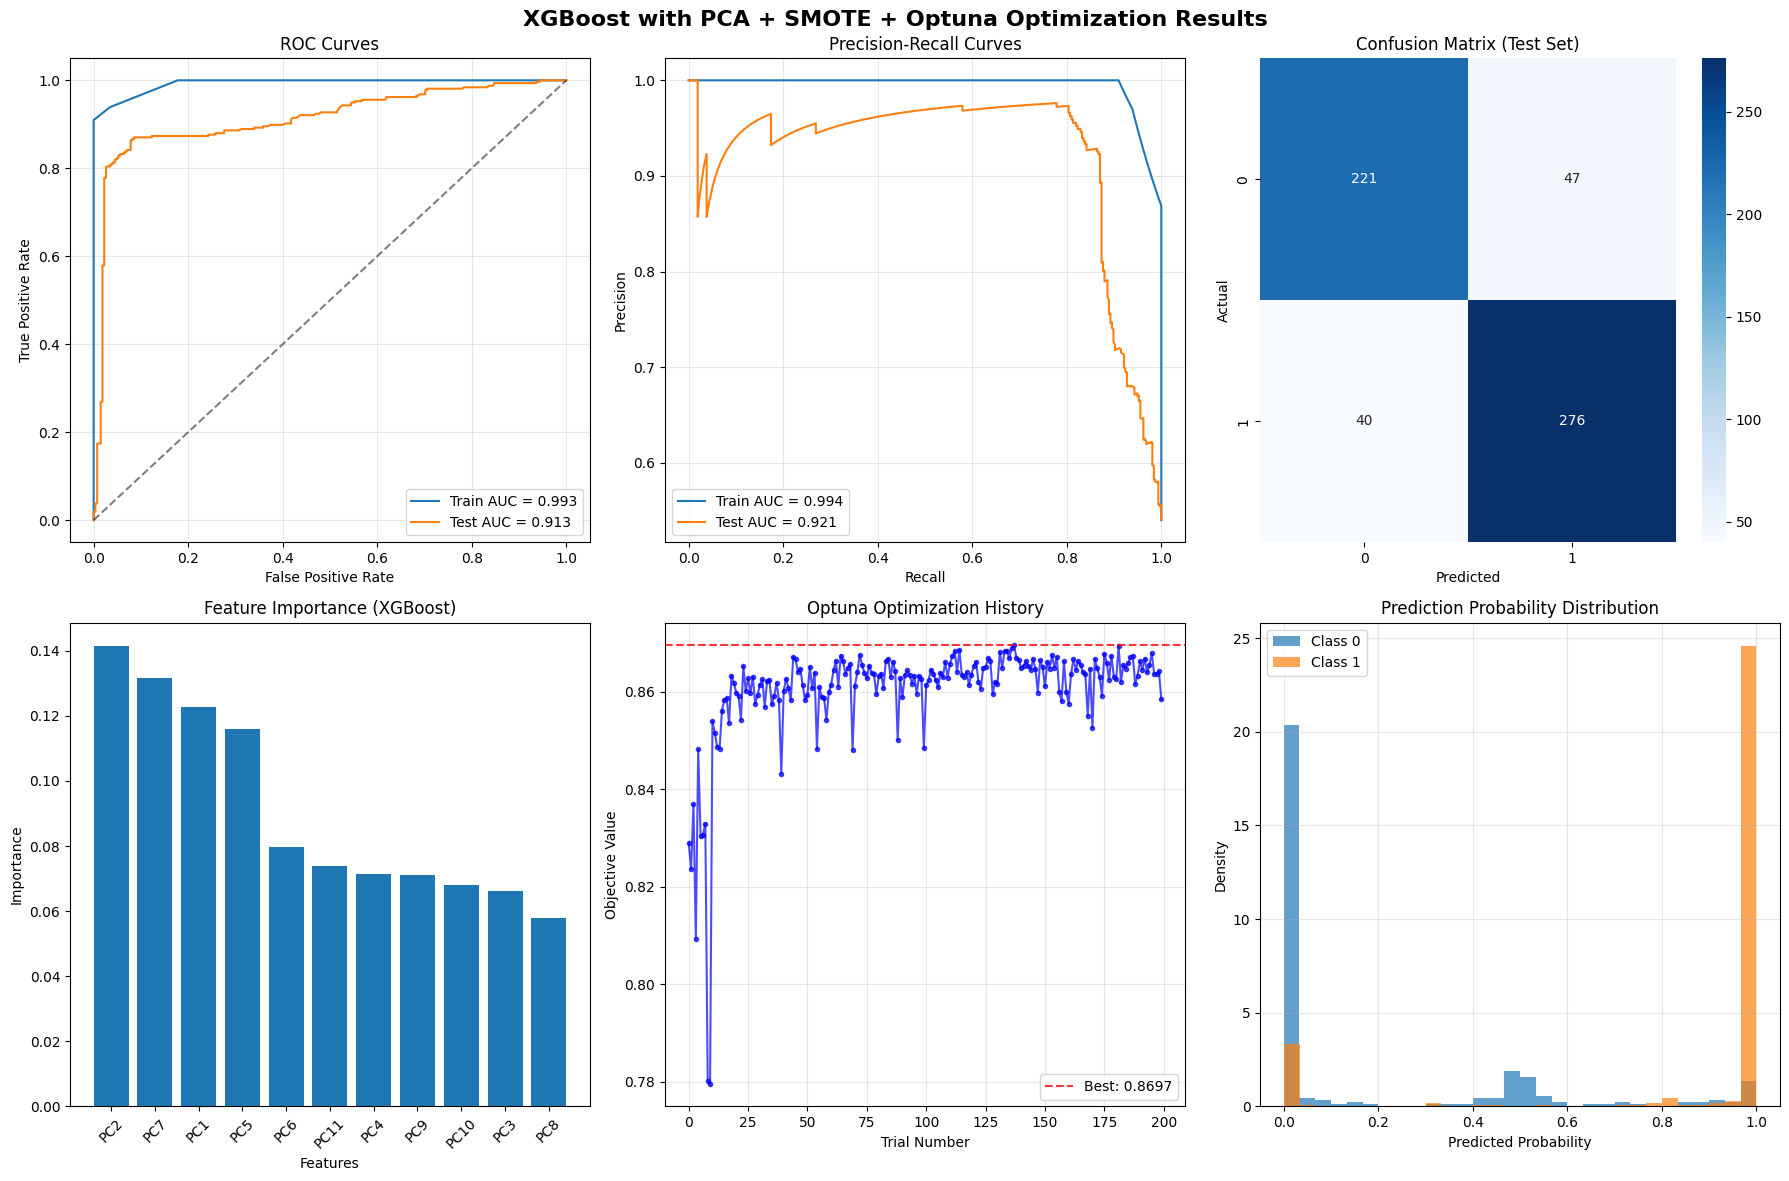

In [ ]:
def plot_results(model, X_test, y_test, X_train, y_train, optuna_study):
    """Create comprehensive visualizations."""
    print("\n" + "=" * 80)
    print("CREATING VISUALIZATIONS")
    print("=" * 80)
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('XGBoost with PCA + SMOTE + Optuna Optimization Results', fontsize=16, fontweight='bold')  # Updated title
    
    # 1. ROC Curves
    y_pred_proba_train = model.predict_proba(X_train)[:, 1]
    y_pred_proba_test = model.predict_proba(X_test)[:, 1]
    
    fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_proba_train)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_proba_test)
    
    axes[0, 0].plot(fpr_train, tpr_train, label=f'Train AUC = {roc_auc_score(y_train, y_pred_proba_train):.3f}')
    axes[0, 0].plot(fpr_test, tpr_test, label=f'Test AUC = {roc_auc_score(y_test, y_pred_proba_test):.3f}')
    axes[0, 0].plot([0, 1], [0, 1], 'k--', alpha=0.5)
    axes[0, 0].set_xlabel('False Positive Rate')
    axes[0, 0].set_ylabel('True Positive Rate')
    axes[0, 0].set_title('ROC Curves')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Precision-Recall Curves
    precision_train, recall_train, _ = precision_recall_curve(y_train, y_pred_proba_train)
    precision_test, recall_test, _ = precision_recall_curve(y_test, y_pred_proba_test)
    
    axes[0, 1].plot(recall_train, precision_train, label=f'Train AUC = {auc(recall_train, precision_train):.3f}')
    axes[0, 1].plot(recall_test, precision_test, label=f'Test AUC = {auc(recall_test, precision_test):.3f}')
    axes[0, 1].set_xlabel('Recall')
    axes[0, 1].set_ylabel('Precision')
    axes[0, 1].set_title('Precision-Recall Curves')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Confusion Matrix (Test Set)
    y_pred_test = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred_test)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 2])
    axes[0, 2].set_title('Confusion Matrix (Test Set)')
    axes[0, 2].set_xlabel('Predicted')
    axes[0, 2].set_ylabel('Actual')
    
    # 4. Feature Importance (from XGBoost)
    if hasattr(model.named_steps['xgb'], 'feature_importances_'):
        feature_names = [f'PC{i+1}' for i in range(len(model.named_steps['xgb'].feature_importances_))]
        importances = model.named_steps['xgb'].feature_importances_
        
        # Sort by importance
        indices = np.argsort(importances)[::-1]
        
        axes[1, 0].bar(range(len(importances)), importances[indices])
        axes[1, 0].set_title('Feature Importance (XGBoost)')
        axes[1, 0].set_xlabel('Features')
        axes[1, 0].set_ylabel('Importance')
        axes[1, 0].set_xticks(range(len(importances)))
        axes[1, 0].set_xticklabels([feature_names[i] for i in indices], rotation=45)
    
    # 5. Optuna Optimization History
    trials_df = optuna_study.trials_dataframe()
    completed_trials = trials_df[trials_df['state'] == 'COMPLETE']
    
    if not completed_trials.empty:
        axes[1, 1].plot(completed_trials.index, completed_trials['value'], 'b-', alpha=0.7, marker='o', markersize=3)
        axes[1, 1].axhline(y=optuna_study.best_value, color='red', linestyle='--', alpha=0.8, label=f'Best: {optuna_study.best_value:.4f}')
        axes[1, 1].set_title('Optuna Optimization History')
        axes[1, 1].set_xlabel('Trial Number')
        axes[1, 1].set_ylabel('Objective Value')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
    else:
        axes[1, 1].text(0.5, 0.5, 'No completed trials', ha='center', va='center', transform=axes[1, 1].transAxes)
        axes[1, 1].set_title('Optuna Optimization History')
    
    # 6. Prediction Distribution
    axes[1, 2].hist(y_pred_proba_test[y_test == 0], bins=30, alpha=0.7, label='Class 0', density=True)
    axes[1, 2].hist(y_pred_proba_test[y_test == 1], bins=30, alpha=0.7, label='Class 1', density=True)
    axes[1, 2].set_title('Prediction Probability Distribution')
    axes[1, 2].set_xlabel('Predicted Probability')
    axes[1, 2].set_ylabel('Density')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Save plot
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    plot_filename = f'xgboost_pca_smote_optuna_analysis_{timestamp}.png'  # Updated filename
    plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
    print(f"Analysis plot saved as: {plot_filename}")
    
    plt.show()

# Create visualizations
plot_results(best_model, X_test, y_test, X_train, y_train, optuna_study)
